In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import tabulate
from  matplotlib.ticker import FuncFormatter
from indic_transliteration.sanscript import SchemeMap, SCHEMES, transliterate
from indic_transliteration import sanscript


sns.set_style("whitegrid")
pd.set_option("styler.format.decimal", ",")
pd.set_option("styler.format.precision", 2)
pd.set_option("styler.format.na_rep", "–")
pd.set_option("mode.chained_assignment", None)
cm = "YlOrRd"#sns.color_palette("blend:white,green", as_cmap=True)

SIGNIFICANCE = 0.01

# use χ² (not fisher exact) because of large sample size
chi2_p = lambda contingency: scipy.stats.chi2_contingency(contingency)[1]

def write_table(df, the_name, caption="", heatmap=False):
    with open(f"table-{the_name}.tex", "w") as f:
        f.write((df.style if not heatmap else df.style.background_gradient(axis="index", cmap=cm)).to_latex(hrules=True, sparse_index=False, environment="longtable", position="!hbt", caption=caption, label="tbl:"+the_name))

In [2]:
df = pd.read_csv("shloka/mahabharata.csv").rename(columns={
    "parvan": "Parvan",
    "adhyaya": "Adhyāya",
    "shloka": "Śloka",
    "pada": "Pāda",
    "type": "Art",
    "text": "Text",
    "syllables": "Silben",
    "lengths": "Quantitäten + Wortgrenzen"
})

In [95]:
df["Quantitäten"] = df["Quantitäten + Wortgrenzen"].apply(lambda x: x.replace(".", ""))
df["Stelle"] = df.apply(lambda x: "{}.{}.{}{}".format(x["Parvan"], x["Adhyāya"], x["Śloka"], x["Pāda"]), axis=1)
df["Text"] = df["Text"].apply(lambda x: transliterate(x, sanscript.HK, sanscript.IAST))
df = df.set_index("Stelle")

In [100]:
shlokas_all = df[(df["Art"] == "Verse") & (~df["Text"].str.contains(";"))]
shlokas_all["Silbenzahl"] = shlokas_all["Quantitäten"].str.len()

# Textsorten

In [5]:
pd.crosstab(df["Art"], df["Parvan"])

Parvan,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Art,,,,,,,,,,,,,,,,,,
Heading,859,286,1076,239,522,253,354,160,153,44,55,1100,725,291,72,15,21,11
Prose,581,0,189,0,0,0,0,0,0,0,0,287,0,0,0,0,0,0
Verse,14345,4863,21197,3758,12433,11199,16712,8056,6940,1589,1495,26231,13403,5648,2174,554,213,399


## Silbenzahlen (_hypermetric_, _catalectic_)

In [78]:
syllable_counts = pd.DataFrame(shlokas_all["Silbenzahl"].value_counts())
write_table(syllable_counts, "syllable_counts", caption="Verteilung der Silbenzahlen innerhalb der Kurzverse")
syllable_counts

,Silbenzahl
16,141658
17,281
13,2
15,1


In [96]:
# catalectic
catalectic_shlokas = shlokas_all[shlokas_all["Silbenzahl"] < 16][["Text", "Silbenzahl"]]
write_table(catalectic_shlokas, "catalectic_shlokas", caption="Shlokas mit Silbenzahl < 16")
catalectic_shlokas

,Text,Silbenzahl
50709,dvādaśapūgāṃ saritaṃ devarakṣitam,13
50710,madhu īśantas tadā saṃcaranti ghoram,13
117933,punaḥ punar vivardheta svalpo 'py anivāritaḥ,15


In [101]:
# hypermetric
hypermetric_shlokas_resolution = shlokas_all[(shlokas_all["Silbenzahl"] > 16) & (shlokas_all["Quantitäten"].str[0:2] == "LL")][["Text", "Quantitäten", "Silbenzahl"]]
write_table(hypermetric_shlokas_resolution, "hypermetric_shlokas_resolution", caption="Verse mit Silbenzahl > 16, Auflösung der ersten Silbe")
hypermetric_shlokas_resolution

,Text,Quantitäten,Silbenzahl
Stelle,,,
1.1.8a,janamejayasya rājarṣeḥ sarpasatre mahātmanaḥ,LLGLGLGGGGLGGLGLL,17
1.1.18a,janamejayasya yāṃ rājño vaiśaṃpāyana uktavān,LLGLGLGGGGGGLLGLG,17
1.1.57a,janamejayena pṛṣṭaḥ san brāhmaṇaiś ca sahasraśaḥ,LLGLGLGGGGLGLLGLL,17
1.2.49a,abhimanyunā ca vairāṭyāḥ parva vaivāhikaṃ smṛtam,LLGLGLGGGGLGGLGLL,17
1.3.182c,janamejayaḥ prasannātmā samyak saṃpūjya taṃ munim,LLGLGLGGGGGGGLGLL,17
...,...,...,...
14.95.7a,parighṛṣṭikā vaighasikāḥ saṃprakṣālās tathaiva ca,LLGLGGLLGGGGGLGLL,17
15.7.8a,vidurādayaś ca te sarve rurudur duḥkhitā bhṛśam,LLGLGLGGGLLGGLGLL,17
15.12.7c,aṭavībalaṃ bhṛtaṃ caiva tathā śreṇībalaṃ ca yat,LLGLGLGGLLGGGLGLL,17


In [102]:
# hypermetric without #LL
hypermetric_shlokas_no_resolution = shlokas_all[(shlokas_all["Silbenzahl"] > 16) & (shlokas_all["Quantitäten"].str[0:2] != "LL")].sort_values(by="Parvan")[["Text", "Silbenzahl"]]
write_table(hypermetric_shlokas_no_resolution, "hypermetric_shlokas_no_resolution", caption="Verse mit Silbenzahl > 16, keine Auflösung der ersten Silbe")
hypermetric_shlokas_no_resolution

,Text,Silbenzahl
Stelle,,
1.69.30a,retodhāḥ putra unnayati naradeva yamakṣayāt,17
1.90.32a,retodhāḥ putra unnayati naradeva yamakṣayāt,17
3.133.11a,na tena sthaviro bhavati yenāsya palitaṃ śiraḥ,17
3.133.25a,kiṃ svit suptaṃ na nimiṣati kiṃ svij jātaṃ na ...,17
3.297.26a,kiṃ svid ādityam unnayati ke ca tasyābhitaś carāḥ,17
3.297.28a,kena svic chrotriyo bhavati kena svid vindate ...,17
3.297.28c,kena dvitīyavān bhavati rājan kena ca buddhimān,17
3.297.29a,śrutena śrotriyo bhavati tapasā vindate mahat,17
3.297.29c,dhṛtyā dvitīyavān bhavati buddhimān vṛddhasevayā,17


In [104]:
shlokas = shlokas_all[shlokas_all["Silbenzahl"] == 16]

# _Pathyā_ oder _Vipulā_

In [11]:
shlokas["Typ"] = shlokas["Quantitäten"].apply(lambda lengths: "Pathyā" if lengths[4:7] == "LGG" else "Vipulā")

In [12]:
shlokas["Typ"].value_counts()

Pathyā    122245
Vipulā     19413
Name: Typ, dtype: int64

<AxesSubplot:xlabel='Parvan', ylabel='Anteil'>

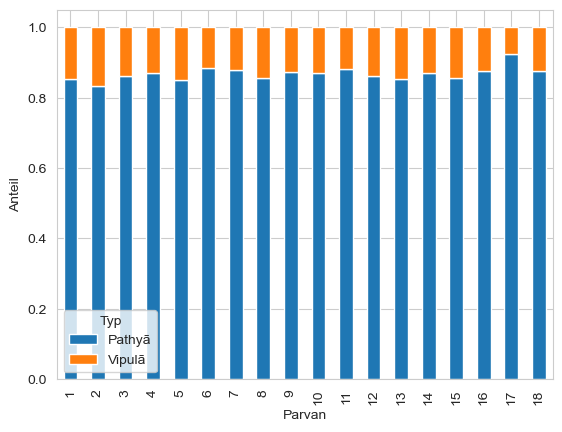

In [13]:
pd.crosstab(shlokas["Parvan"], shlokas["Typ"], normalize="index").plot.bar(stacked=True, ylabel="Anteil")

In [14]:
contingency_parvan_type = pd.crosstab(shlokas["Parvan"], shlokas["Typ"])

scipy.stats.contingency.association(contingency_parvan_type), chi2_p(contingency_parvan_type)

(0.03487174855084843, 9.986436779922493e-28)

In [106]:
shlokas["opening"] = shlokas["Quantitäten"].apply(lambda ls: ls[0:4])
shlokas["semi-cadence"] = shlokas["Quantitäten"].apply(lambda ls: ls[4:7])
shlokas["reopening"] = shlokas["Quantitäten"].apply(lambda ls: ls[8:12])
shlokas["cadence"] = shlokas["Quantitäten"].apply(lambda ls: ls[12:15])

## Welche _Vipulā_ gibt es?

In [16]:
# Vipulās
shlokas["semi-cadence"].value_counts()

LGG    122245
LLL      7351
GGG      5513
GLL      4479
GLG      1893
LGL       110
LLG        56
GGL        11
Name: semi-cadence, dtype: int64

In [17]:
# Cadence
shlokas["cadence"].value_counts()

LGL    141556
GGL       101
LLL         1
Name: cadence, dtype: int64

In [128]:
odd_semi_cadences = shlokas[shlokas["semi-cadence"].apply(lambda x: x in ["LGL", "LLG", "GGL"])].reset_index().set_index(["semi-cadence", "Stelle"]).sort_index()[["Text", "Quantitäten"]]
write_table(odd_semi_cadences, "odd_semi_cadences", caption="Verse mit unüblicher semi-cadence.")
odd_semi_cadences

Text  \
semi-cadence Stelle                                                          
GGL          1.57.93a        prahrādaśiṣyo nagnajit subalaś cābhavat tataḥ   
             1.92.13e     kulasya ye vaḥ prasthitās tatsādhutvam anuttamam   
             10.7.49c       tān prekṣamāṇo 'pi vyathāṃ na cakāra mahābalaḥ   
             12.112.65a  sthāpito 'yaṃ putra tvayā sāmanteṣv adhi viśrutaḥ   
             13.41.27c         akiṃcid uktvā vrīḍitas tatraivāntaradhīyata   
...                                                                    ...   
LLG          8.52.9a       adya rājā dhṛtarāṣṭraḥ svāṃ buddhim avamaṃsyate   
             8.56.55c           aśvatthāmā kṛtavarmā śakuniś cāpi saubalaḥ   
             8.58.10a          catuḥśatāḥ śaravarṣair hatāḥ petuḥ kirīṭinā   
             9.28.32c          mahāvanam iva chinnam abhavat tāvakaṃ balam   
             9.8.46a      hayān dvipāṃs tvarayanto yodhā jagmuḥ samantataḥ   

                              Quantitäten  
semi-cadence Stelle                        
GGL          1.57.93a    GGLGGGLGLLGGLGLL  
             1.92.13e    LGLGGGLGGGGLLGLL  
             10.7.49c    GGLGGGLGLLGLLGLL  
             12.112.65a  GLGGGGLGGGGLLGLL  
             13.41.27c   LGLGGGLGGGGLLGLL  
...                                   ...  
LLG          8.52.9a     GLGGLLGGGGLLLGLG  
             8.56.55c    GGGGLLGGLLGGLGLL  
             8.58.10a    LGLGLLGGLGGGLGLG  
             9.28.32c    LGLLLLGLLLGGLGLL  
             9.8.46a     LGLGLLGGGGGGLGLL  

[177 rows x 2 columns]

In [129]:
df_no_pathya = shlokas[shlokas["semi-cadence"] != "LGG"]
contingency_semi_cadence_parvan = pd.crosstab(df_no_pathya["semi-cadence"], df_no_pathya["Parvan"])


In [132]:
write_table(contingency_semi_cadence_parvan, "contingency_semi_cadence_parvan", caption="Verteilung der einzelnen semi-cadences auf die Parvans.", heatmap=True)
contingency_semi_cadence_parvan.style.background_gradient(axis="index", cmap=cm)


Parvan,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
semi-cadence,,,,,,,,,,,,,,,,,,
GGG,582,191,840,198,523,300,545,242,185,70,61,930,492,223,89,19,3,20
GGL,2,1,1,0,3,1,0,0,0,1,0,1,1,0,0,0,0,0
GLG,232,113,247,41,183,136,195,93,76,10,3,318,177,46,10,10,1,2
GLL,446,145,590,101,329,314,539,272,221,41,41,783,422,138,71,14,1,11
LGL,3,1,1,0,7,2,1,0,0,0,0,94,1,0,0,0,0,0
LLG,3,3,3,1,6,4,4,4,2,0,0,16,7,2,1,0,0,0
LLL,698,306,1060,111,586,470,688,358,361,80,71,1341,756,289,132,18,10,16


In [21]:
scipy.stats.contingency.association(contingency_semi_cadence_parvan), chi2_p(contingency_semi_cadence_parvan)

(0.07492031814433946, 2.183287721142512e-81)

## Zusammenhänge zwischen _semi-cadence_ und _(re)opening_

In [22]:
contingency_semi_cadence_opening = pd.crosstab(shlokas["semi-cadence"], shlokas["opening"])

In [134]:
write_table(contingency_semi_cadence_opening, "contingency_semi_cadence_opening", caption="Häufigkeit der Kombinationen aus semi-cadence und opening.", heatmap=True)
contingency_semi_cadence_opening.style.background_gradient(axis=None, cmap=cm)

opening,GGGG,GGGL,GGLG,GGLL,GLGG,GLGL,GLLG,GLLL,LGGG,LGGL,LGLG,LGLL,LLGG,LLGL,LLLG,LLLL
semi-cadence,,,,,,,,,,,,,,,,
GGG,30,3,2487,6,23,8,1,0,16,3,2918,2,8,7,1,0
GGL,1,0,4,0,1,0,0,0,0,1,2,0,1,1,0,0
GLG,328,1,516,0,201,0,2,0,219,0,588,0,36,1,1,0
GLL,139,4,1979,1,92,0,1,0,108,0,2128,0,24,2,1,0
LGG,15180,9321,6418,8787,19062,11664,5,6,12438,8336,6771,7312,11310,5631,2,2
LGL,4,1,2,1,0,0,0,0,1,0,98,1,2,0,0,0
LLG,18,1,6,1,8,1,0,0,6,2,5,3,5,0,0,0
LLL,1539,3,814,0,1989,0,0,0,1271,0,844,0,891,0,0,0


In [24]:
scipy.stats.contingency.association(contingency_semi_cadence_opening), chi2_p(contingency_semi_cadence_opening)

(0.23109316137405628, 0.0)

In [25]:
contingency_semi_cadence_reopening = pd.crosstab(shlokas["semi-cadence"], shlokas["reopening"])
write_table(contingency_semi_cadence_reopening, "contingency_semi_cadence_reopening", caption="Häufigkeit der Kombinationen aus semi-cadence und reopening.", heatmap=True)

In [26]:
contingency_semi_cadence_reopening.style.background_gradient(axis=None, cmap=cm)

reopening,GGGG,GGGL,GGLG,GGLL,GLGG,GLGL,GLLG,GLLL,LGGG,LGGL,LGLG,LGLL,LLGG,LLGL,LLLG,LLLL
semi-cadence,,,,,,,,,,,,,,,,
GGG,790,618,1,442,934,545,0,0,667,458,1,289,495,273,0,0
GGL,3,3,0,1,0,0,0,0,1,0,0,1,1,1,0,0
GLG,317,193,1,138,318,175,0,0,228,145,0,112,173,93,0,0
GLL,703,429,1,372,765,442,0,0,477,400,0,247,423,220,0,0
LGG,17178,12469,12,10356,20674,12777,1,5,13469,9781,22,6961,12174,6363,2,1
LGL,5,1,0,1,2,0,0,0,5,16,78,0,2,0,0,0
LLG,14,2,0,4,10,0,0,0,13,2,0,5,5,1,0,0
LLL,1103,749,0,632,1261,752,0,0,824,562,0,432,676,360,0,0


In [27]:
scipy.stats.contingency.association(contingency_semi_cadence_reopening), chi2_p(contingency_semi_cadence_reopening)

(0.27986558493409697, 0.0)

In [28]:
contingency_opening_reopening = pd.crosstab(shlokas["opening"], shlokas["reopening"])

In [29]:
contingency_opening_reopening.style.background_gradient(axis=None, cmap=cm)

reopening,GGGG,GGGL,GGLG,GGLL,GLGG,GLGL,GLLG,GLLL,LGGG,LGGL,LGLG,LGLL,LLGG,LLGL,LLLG,LLLL
opening,,,,,,,,,,,,,,,,
GGGG,2740,1774,1,1455,2868,1700,0,2,2030,1303,1,915,1615,834,1,0
GGGL,1381,962,0,838,1543,952,0,1,1102,737,2,526,858,432,0,0
GGLG,1782,1279,4,946,2041,1211,0,0,1391,980,2,658,1317,614,1,0
GGLL,1142,870,1,794,1531,936,0,0,954,724,3,488,886,467,0,0
GLGG,3018,2227,5,1830,3673,2277,1,1,2267,1621,5,1231,2107,1113,0,0
GLGL,1585,1197,0,957,1953,1277,0,0,1239,986,1,693,1167,618,0,0
GLLG,2,0,0,0,2,0,0,0,2,2,0,1,0,0,0,0
GLLL,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0
LGGG,2075,1437,1,1156,2425,1454,0,0,1591,1063,2,747,1380,728,0,0


In [30]:
scipy.stats.contingency.association(contingency_opening_reopening), chi2_p(contingency_opening_reopening)

(0.022004715122103145, 5.384541206103315e-103)

# Einzelne _akṣara_ im Vers

In [31]:
shlokas["tmp_syllables"] = shlokas["Quantitäten"].apply(lambda x: list(enumerate(x, start=1)))
silbenweise = shlokas.explode("tmp_syllables")
silbenweise["Position"] = silbenweise["tmp_syllables"].apply(lambda x: x[0])
silbenweise["Quantität"] = silbenweise["tmp_syllables"].apply(lambda x: x[1])
shlokas.drop(columns="tmp_syllables", inplace=True)

In [142]:
contingency_quantity_position = pd.crosstab(silbenweise["Quantität"], silbenweise["Position"])
write_table(contingency_quantity_position, "contingency_quantity_position", caption="Häufigkeit der Quantitäten an den einzelnen Vers-Positionen", heatmap=True)

In [141]:
contingency_quantity_position.style.background_gradient(axis="columns", cmap=cm)

Position,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Quantität,,,,,,,,,,,,,,,,
G,80659,90668,99942,90545,11896,127879,129707,97887,85199,81734,121540,73829,101,141657,0,54236
L,60999,50990,41716,51113,129762,13779,11951,43771,56459,59924,20118,67829,141557,1,141658,87422


In [143]:
scipy.stats.contingency.association(contingency_quantity_position), chi2_p(contingency_quantity_position)

(0.6107195337733208, 0.0)

In [34]:
nur_guru = silbenweise[silbenweise["Quantität"] == "G"]

In [146]:
contingency_semi_cadence_position = pd.crosstab(
    nur_guru["semi-cadence"], 
    nur_guru["Position"]
).sort_values(14, ascending=False)
write_table(contingency_semi_cadence_position, "contingency_semi_cadence_position", caption="Häufigkeit schwerer Silben, abhängig von der semi-cadence des Verses", heatmap=True)

In [147]:
contingency_semi_cadence_position.style.background_gradient(axis="columns", cmap=cm)

Position,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16
semi-cadence,,,,,,,,,,,,,,,
LGG,70443,74563,92942,71186,0,122245,122245,81601,73472,70248,104885,63532,92,122244,46673
LLL,4345,4471,5693,7348,0,0,0,6975,4497,4302,6287,3864,0,7351,2862
GGG,2558,5465,98,5484,5513,5513,5513,3612,3330,3266,4780,2888,4,5513,2123
GLL,2216,4359,369,4472,4479,0,0,4107,2712,2629,3859,2369,1,4479,1778
GLG,1048,1652,786,1891,1893,0,1893,1443,1142,1134,1642,1037,4,1893,724
LGL,8,108,8,107,0,110,0,90,9,106,31,92,0,110,48
LLG,35,42,41,48,0,0,56,49,30,40,47,42,0,56,25
GGL,6,8,5,9,11,11,0,10,7,9,9,5,0,11,3


In [37]:
# no effect to be seen, also tried with .reopening and .cadence
pd.crosstab(
    nur_guru["reopening"], 
    nur_guru["Position"]
).sort_values(14, ascending=False).style.background_gradient(axis="columns", cmap=cm)

Position,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16
reopening,,,,,,,,,,,,,,,
GLGG,13614,15370,16832,15276,2017,21610,21936,16892,23964,0,23964,23964,16,23964,9271
GGGG,11650,13062,14425,13273,1813,17976,18299,13924,20113,20113,20113,20113,30,20112,7758
LGGG,8985,10229,11063,10154,1373,14142,14377,10644,0,15684,15684,15684,16,15684,6101
GLGL,8356,9223,10402,9224,1162,13322,13497,10223,14691,0,14691,0,5,14691,5610
GGGL,8309,9141,10293,9322,1243,13091,13282,9819,14464,14464,14464,0,3,14464,5580
LLGG,7950,8966,9708,8843,1092,12672,12847,9402,0,0,13949,13949,16,13949,5286
GGLL,6820,7628,8458,7559,953,10800,10940,8168,11946,11946,0,0,6,11946,4488
LGGL,6353,7270,7909,7126,1003,10255,10386,7900,0,11364,11364,0,2,11364,4386
LGLL,4512,5046,5681,5019,649,7251,7367,5718,0,8047,0,0,7,8047,3031


In [38]:
effects = np.ndarray((16,16))

for i in range(16):
    for j in range(16):
        contingency = pd.crosstab(shlokas["Quantitäten"].str[i], shlokas["Quantitäten"].str[j])
        effects[i, j] = scipy.stats.contingency.association(contingency) if chi2_p(contingency) < SIGNIFICANCE else np.nan

In [149]:
cross_syllable_effects = pd.DataFrame(effects).rename(index=lambda x: x+1, columns=lambda x: x+1)
write_table(cross_syllable_effects, "cross_syllable_effects", caption=f"Zusammenhänge zwischen den Quantitäten einzelner Silben (Cramérs $V$, nur signifikante Effekte: $p < {SIGNIFICANCE}$)", heatmap=True)

/nix/store/7aqbi1mp9yzcwaj3vdybfcja093kj22k-python3-3.10.8-env/lib/python3.10/site-packages/pandas/io/formats/style.py:3555: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/nix/store/7aqbi1mp9yzcwaj3vdybfcja093kj22k-python3-3.10.8-env/lib/python3.10/site-packages/pandas/io/formats/style.py:3556: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


In [150]:
cross_syllable_effects.style.background_gradient(axis=None, cmap=cm)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,"1,00","0,12","0,08","0,02","0,05","0,01","0,01","0,01","0,01",–,–,–,–,–,–,"0,01"
2,"0,12","1,00","0,48","0,03","0,21","0,08","0,07","0,01",–,–,–,"0,01",–,–,–,–
3,"0,08","0,48","1,00","0,03","0,40","0,15","0,13","0,04","0,01",–,–,–,–,–,–,–
4,"0,02","0,03","0,03","1,00","0,23","0,25","0,23",–,–,"0,01","0,01","0,01",–,–,–,–
5,"0,05","0,21","0,40","0,23","1,00","0,45","0,32","0,05",–,"0,01",–,–,–,–,–,–
6,"0,01","0,08","0,15","0,25","0,45","1,00","0,91","0,16",–,"0,01",–,–,–,–,–,–
7,"0,01","0,07","0,13","0,23","0,32","0,91","1,00","0,16",–,"0,01",–,–,–,–,–,–
8,"0,01","0,01","0,04",–,"0,05","0,16","0,16","1,00",–,–,–,–,–,–,–,"0,01"
9,"0,01",–,"0,01",–,–,–,–,–,"1,00","0,08",–,"0,01",–,–,–,–
10,–,–,–,"0,01","0,01","0,01","0,01",–,"0,08","1,00","0,35","0,19",–,–,–,–


In [47]:
counts_laghu = np.ndarray((16,16))
counts_guru = np.ndarray((16,16))

for i in range(16):
    for j in range(16):
        try:
            counts_laghu[i, j] = shlokas[shlokas["Quantitäten"].str[i] == "L"]["Quantitäten"].str[j].value_counts(normalize=True)["G"]
        except:
            counts_laghu[i, j] = 0
        try:
            counts_guru[i, j] = shlokas[shlokas["Quantitäten"].str[i] == "G"]["Quantitäten"].str[j].value_counts(normalize=True)["G"]
        except:
            counts_guru[i, j] = 0

In [152]:
conditioned_syllable_laghu = pd.DataFrame(counts_laghu).rename(index=lambda x: f"{x+1}=L", columns=lambda x: f"→{x+1}=G")
write_table(conditioned_syllable_laghu, "conditioned_syllable_laghu", caption="Bedingte Wahrscheinlichkeiten für schwere Silben, abhängig von einer bestimmten leichten Silbe")
conditioned_syllable_laghu.style.background_gradient(axis=None, cmap=cm)

,→1=G,→2=G,→3=G,→4=G,→5=G,→6=G,→7=G,→8=G,→9=G,→10=G,→11=G,→12=G,→13=G,→14=G,→15=G,→16=G
1=L,"0,00","0,71","0,66","0,65","0,10","0,90","0,91","0,70","0,60","0,58","0,86","0,52","0,00","1,00","0,00","0,38"
2=L,"0,65","0,00","1,00","0,66","0,01","0,94","0,94","0,68","0,60","0,57","0,86","0,51","0,00","1,00","0,00","0,38"
3=L,"0,50","1,00","0,00","0,61","0,26","0,83","0,86","0,72","0,59","0,57","0,86","0,52","0,00","1,00","0,00","0,38"
4=L,"0,58","0,66","0,68","0,00","0,00","1,00","1,00","0,69","0,60","0,57","0,85","0,51","0,00","1,00","0,00","0,38"
5=L,"0,58","0,61","0,76","0,61","0,00","0,94","0,94","0,68","0,60","0,58","0,86","0,52","0,00","1,00","0,00","0,38"
6=L,"0,55","0,76","0,50","1,00","0,46","0,00","0,14","0,91","0,61","0,59","0,86","0,53","0,00","1,00","0,00","0,39"
7=L,"0,55","0,75","0,51","1,00","0,38","0,01","0,00","0,94","0,60","0,59","0,85","0,53","0,00","1,00","0,00","0,39"
8=L,"0,58","0,63","0,73","0,64","0,06","0,97","0,98","0,00","0,60","0,58","0,86","0,52","0,00","1,00","0,00","0,37"
9=L,"0,56","0,64","0,70","0,64","0,08","0,90","0,92","0,69","0,00","0,62","0,86","0,53","0,00","1,00","0,00","0,38"
10=L,"0,57","0,64","0,70","0,63","0,08","0,91","0,92","0,69","0,65","0,00","1,00","0,63","0,00","1,00","0,00","0,38"


In [151]:
conditioned_syllable_guru = pd.DataFrame(counts_guru).rename(index=lambda x: f"{x+1}=G", columns=lambda x: f"→{x+1}=G")
write_table(conditioned_syllable_guru, "conditioned_syllable_guru", caption="Bedingte Wahrscheinlichkeiten für schwere Silben, abhängig von einer bestimmten leichten Silbe")
conditioned_syllable_guru.style.background_gradient(axis=None, cmap=cm)

,→1=G,→2=G,→3=G,→4=G,→5=G,→6=G,→7=G,→8=G,→9=G,→10=G,→11=G,→12=G,→13=G,→14=G,→15=G,→16=G
1=G,"1,00","0,59","0,74","0,63","0,07","0,91","0,92","0,69","0,60","0,58","0,86","0,52","0,00","1,00","0,00","0,39"
2=G,"0,52","1,00","0,54","0,63","0,13","0,88","0,90","0,70","0,60","0,58","0,86","0,53","0,00","1,00","0,00","0,38"
3=G,"0,60","0,49","1,00","0,65","0,01","0,93","0,94","0,68","0,60","0,58","0,86","0,52","0,00","1,00","0,00","0,38"
4=G,"0,56","0,63","0,72","1,00","0,13","0,85","0,87","0,69","0,60","0,58","0,86","0,53","0,00","1,00","0,00","0,39"
5=G,"0,49","0,97","0,11","1,00","1,00","0,46","0,62","0,77","0,60","0,59","0,86","0,53","0,00","1,00","0,00","0,39"
6=G,"0,57","0,63","0,73","0,60","0,04","1,00","1,00","0,67","0,60","0,58","0,86","0,52","0,00","1,00","0,00","0,38"
7=G,"0,57","0,63","0,72","0,61","0,06","0,98","1,00","0,67","0,60","0,58","0,86","0,52","0,00","1,00","0,00","0,38"
8=G,"0,57","0,64","0,69","0,64","0,09","0,87","0,89","1,00","0,60","0,57","0,86","0,52","0,00","1,00","0,00","0,39"
9=G,"0,57","0,64","0,71","0,64","0,08","0,90","0,92","0,69","1,00","0,55","0,86","0,52","0,00","1,00","0,00","0,38"
10=G,"0,57","0,64","0,71","0,64","0,09","0,90","0,91","0,69","0,57","1,00","0,75","0,44","0,00","1,00","0,00","0,38"


In [39]:
def cross_examine(position1, position2):
    return pd.crosstab(
        shlokas["Quantitäten"].str[position1-1].rename(position1), 
        shlokas["Quantitäten"].str[position2-1].rename(position2)
    )

In [40]:
# Piṅgala Syllables 2 and 3
cross_examine(2, 3)

3,G,L
2,,
G,48974,41694
L,50968,22


In [41]:
cross_examine(10,11)

11,G,L
10,,
G,61625,20109
L,59915,9


In [42]:
cross_examine(11,12)

12,G,L
11,,
G,73710,47830
L,119,19999


In [43]:
shlokas["Quantitäten"].str[1:3].value_counts()

LG    50968
GG    48974
GL    41694
LL       22
Name: Quantitäten, dtype: int64

In [44]:
shlokas["Quantitäten"].str[9:12].value_counts()

LGG    37913
GGG    35797
GGL    25828
LGL    22002
GLL    19993
GLG      116
LLL        6
LLG        3
Name: Quantitäten, dtype: int64

In [50]:
effects_quarter = np.ndarray((4,4))
quarters = ["opening", "semi-cadence", "reopening", "cadence"]
for i, quarter_i in enumerate(quarters):
    for j, quarter_j in enumerate(quarters):
        contingency = pd.crosstab(
            shlokas[quarter_i],
            shlokas[quarter_j]
        )
        effects_quarter[i, j] = scipy.stats.contingency.association(contingency) if chi2_p(contingency) < SIGNIFICANCE else np.nan

In [153]:
cross_quarter_effects = pd.DataFrame(effects_quarter).rename(index=lambda x: quarters[x], columns=lambda x: quarters[x])
write_table(cross_quarter_effects, "cross_quarter_effects", caption="Zusammenhänge zwischen den Quantitäten einzelner Viertel (Cramérs $V$, nur signifikante Effekte: $p < {SIGNIFICANCE}$)", heatmap=True)
cross_quarter_effects.style.background_gradient(axis=None, cmap=cm)

,opening,semi-cadence,reopening,cadence
opening,"1,00","0,23","0,02",–
semi-cadence,"0,23","1,00","0,28",–
reopening,"0,02","0,28","1,00",–
cadence,–,–,–,"1,00"


# Wortgrenzen und Zäsuren

In [52]:
def enumerate_sublists(lists):
    index = 1
    result = []
    for element in lists:
        result.append((index, element))
        index += len(element)
    return result

In [53]:
shlokas["tmp_words"] = shlokas.apply(
    lambda row: tuple(zip(
        enumerate_sublists(row["Quantitäten + Wortgrenzen"].split(".")), 
        row["Text"].split(" ")
    )), axis=1)
wortweise = shlokas.explode("tmp_words")
wortweise["Position"] = wortweise["tmp_words"].apply(lambda x: x[0][0])
wortweise["Sequenz"] = wortweise["tmp_words"].apply(lambda x: x[0][1])
wortweise["Wort"] = wortweise["tmp_words"].apply(lambda x: x[1])
shlokas.drop(columns="tmp_words", inplace=True)

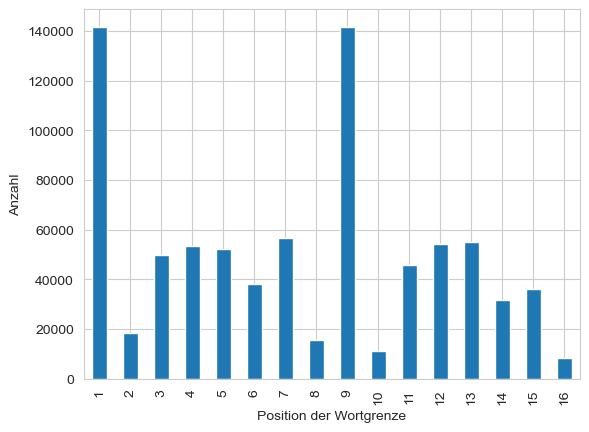

In [159]:
wortweise["Position"].value_counts().sort_index().plot.bar(xlabel="Position der Wortgrenze", ylabel="Anzahl")
plt.savefig("figure-caesura.svg")

In [154]:
contingency_semi_cadence_position = pd.crosstab(
    wortweise["semi-cadence"], 
    wortweise["Position"]
).sort_values(1, ascending=False)
write_table(contingency_semi_cadence_position, "contingency_semi_cadence_position", caption="Häufigkeit eines Wortanfangs, abhängig von der semi-cadence", heatmap=True)

In [155]:
contingency_semi_cadence_position.style.background_gradient(axis="columns", cmap=cm)

Position,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
semi-cadence,,,,,,,,,,,,,,,,
LGG,122245,15768,43000,49071,45508,26313,54315,14202,122156,9746,39677,47120,47653,27332,31110,7260
LLL,7351,819,2835,1582,3169,3621,834,104,7342,542,2382,2689,2772,1569,1740,424
GGG,5513,844,1968,1614,306,5427,503,851,5516,448,1850,2111,2165,1251,1476,321
GLL,4479,748,1388,916,1321,2708,709,90,4480,323,1473,1628,1777,930,1115,204
GLG,1893,159,650,63,1831,47,152,252,1892,129,566,756,749,428,532,92
LGL,110,33,41,31,27,54,14,5,109,11,24,42,29,26,42,6
LLG,56,4,16,4,51,4,8,4,56,2,23,18,26,16,16,4
GGL,11,1,3,5,5,9,2,0,11,2,2,4,5,2,2,2


In [56]:
scipy.stats.contingency.association(contingency_semi_cadence_position), chi2_p(contingency_semi_cadence_position)

(0.06880148036536655, 0.0)

In [57]:
positions = wortweise["Position"].unique()

def word_break_at(position, qs):
    for index, sublist in enumerate_sublists(qs.split(".")):
        if index == position:
            return True
    return False

effects_break = np.zeros(positions.size)
for position in positions:
    contingency = pd.crosstab(
        shlokas["semi-cadence"],
        shlokas["Quantitäten + Wortgrenzen"].apply(lambda qs: word_break_at(position, qs))
    )
    effects_break[position-1] = scipy.stats.contingency.association(contingency) if chi2_p(contingency) < SIGNIFICANCE else np.nan
    #wortweise[wortweise["semi-cadence"] == "LLL"]["Position"].value_counts()

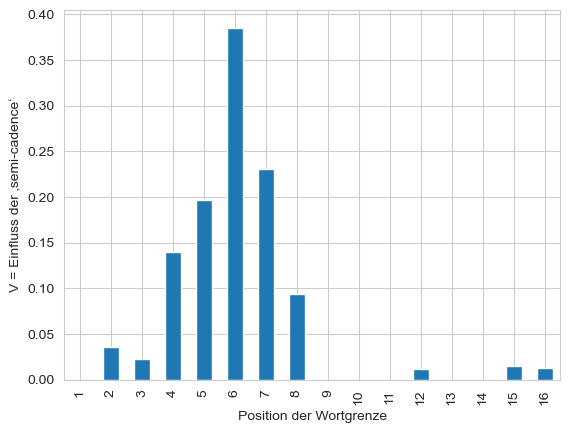

In [158]:
pd.Series(effects_break, index=range(1, 16+1)).plot.bar(xlabel="Position der Wortgrenze", ylabel="V = Einfluss der ‚semi-cadence‘")
plt.savefig("figure-effect-caesura.svg")

In [160]:
contingency_sequence_position = pd.crosstab(
    wortweise["Sequenz"], 
    wortweise["Position"]
).sort_values(1, ascending=False)
write_table(contingency_sequence_position, "contingency_sequence_position", caption="Lokalisierung einzelner metrischer Worttypen im Vers", heatmap=True)

In [60]:
contingency_sequence_position.head(28).style.background_gradient(axis="columns", cmap=cm)

Position,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Sequenz,,,,,,,,,,,,,,,,
GG,18954,3404,11181,2097,1,4009,41870,0,20724,2575,11708,10,0,0,0,0
LG,15024,1877,2023,6,16203,3,1388,0,12577,1336,8,1,9434,0,14383,0
G,10459,2485,5612,3748,565,4964,1887,7127,7046,2031,4938,3737,25,3027,0,2165
GLG,8916,644,2,9143,228,39,0,0,11669,3,6,5388,0,10485,0,0
L,7562,2684,4440,4200,8918,551,56,8376,4081,1386,1737,4574,6766,0,1137,6148
GL,7006,1613,2611,5219,304,2,10793,0,5603,657,4516,5440,0,1623,0,0
GGG,6887,430,21,1,2,13434,0,1,8787,394,32,0,0,0,0,0
LGG,6556,831,1912,3,3035,22,0,1,8250,523,0,0,0,0,0,0
GLGG,5827,823,0,2420,1174,0,3,1,8734,0,0,0,0,0,0,0


In [61]:
scipy.stats.contingency.association(contingency_sequence_position), chi2_p(contingency_sequence_position)

(0.4902626235800064, 0.0)

In [63]:
shlokas["Quantitäten + Wortgrenzen"].apply(
    lambda qs: "_".join(str(x) for x, y in enumerate_sublists(qs.split(".")))
).value_counts()

1_4_7_9_13                 1474
1_5_9_13                   1415
1_4_7_9_12                 1292
1_5_9_12                   1277
1_3_7_9_13                  989
                           ... 
1_5_9_10_12_15_16             1
1_2_4_8_9_12_15_16            1
1_4_9_13_13                   1
1_2_3_4_8_9_10_11_12_15       1
1_5_7_9_10_11_12_13_16        1
Name: Quantitäten + Wortgrenzen, Length: 7250, dtype: int64

# Piṅgalas Verbote

In [169]:
short23 = shlokas[(shlokas.reopening.str[1:3] == "LL") | (shlokas.opening.str[1:3] == "LL")][["Text", "Quantitäten"]]
write_table(short23, "short23", caption="Verse mit Doppelkürze in der Mitte des (re)openings")
short23

,Text,Quantitäten
Stelle,,
1.2.158c,adhyāyānāṃ śataṃ proktaṃ saptadaśa tathāpare,GGGGLGGGGLLLLGLG
1.2.234a,etad akhilam ākhyātaṃ bhārataṃ parvasaṃgrahāt,GLLLLGGGGLGGLGLG
1.39.29c,yad gṛhītaṃ phalaṃ rājñā tatra kṛmir abhūd aṇuḥ,GLGGLGGGGLLLLGLL
1.99.41a,katham arājakaṃ rāṣṭraṃ śakyaṃ dhārayituṃ prabho,LLLGLGGGGGGLLGLG
1.158.14a,na kuṇapāḥ śṛṅgiṇo vā na devā na ca mānuṣāḥ,LLLGGLGGLGGLLGLG
2.10.4a,raśmivatī bhāsvarā ca divyagandhā manoramā,GLLGGLGLGLGGLGLG
2.19.10a,aparihāryā meghānāṃ māgadheyaṃ maṇeḥ kṛte,LLLGGGGGGLGGLGLG
3.222.36c,nāpi parivade śvaśrūṃ sarvadā pariyantritā,GLLLLGGGGLGLLGLG
3.222.39c,nāpi parivade cāhaṃ tāṃ pṛthāṃ pṛthivīsamām,GLLLLGGGGLGLLGLG


In [170]:
reopening_glg = shlokas[(shlokas.reopening.str[1:4] == "GLG")][["Text", "Quantitäten"]]
write_table(reopening_glg, "reopening_glg", caption="Verse mit der Sequenz GLG vor der Kadenz")
reopening_glg
# Interessant auch die Verteilung auf die Parvans: ["parva"].value_counts()

,Text,Quantitäten
Stelle,,
2.47.9a,indrakṛṣṭair vartayanti dhānyair nadīmukhaiś c...,GLGGGLGLGGLGLGLG
3.17.19c,cikṣepa tarasā vīro vyāvidhya satyavikramaḥ,GGLLLGGGGGLGLGLL
3.104.7c,vaśe ca kṛtvā rājño 'nyān svarājyam anvaśāsata,LGLGGGGGLGLGLGLL
3.188.61a,dasyuprapīḍitā rājan kākā iva dvijottamāḥ,GGLGLGGGGGLGLGLG
3.299.16a,hutāśanena yac cāpaḥ praviśya channam āsatā,LGLGLGGGLGLGLGLG
...,...,...
13.101.23a,yajñiyānāṃ ca vṛkṣāṇām ayajñiyān nibodha me,GLGGLGGGLGLGLGLG
13.109.55c,vyādhitasyauṣadhagrāmaḥ kruddhasya ca prasādanam,GLGGLGGGGGLGLGLL
13.151.8c,nāradaḥ parvataś caiva viśvāvasur hahāhuhūḥ,GLGGLGGLGGLGLGLG


# Moren (_mātrā_)

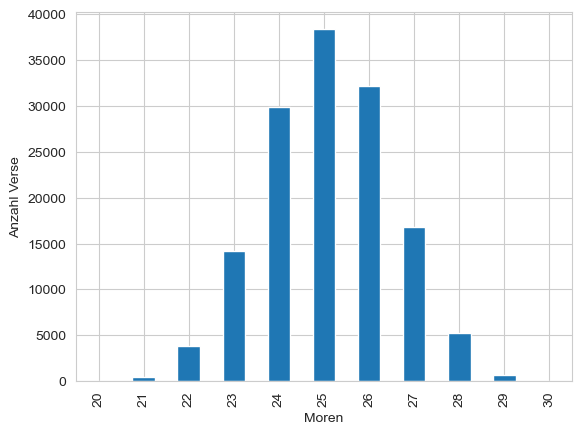

In [176]:
shlokas["Mātrās"] = shlokas["Quantitäten"].apply(lambda ls: sum(2 if c == "G" else 1 for c in ls))
shlokas["Mātrās"].value_counts().sort_index().plot.bar(xlabel="Moren", ylabel="Anzahl Verse")
plt.savefig("figure-morae-count.svg")

In [67]:
shlokas["Mātrās"].mean(), shlokas["Mātrās"].std()

(25.088643069928985, 1.4212093459708697)

In [179]:
shlokas.sort_values(by="Mātrās")[["Text", "Quantitäten", "Mātrās"]].iloc[np.r_[0:8, -8:0]]

,Text,Quantitäten,Mātrās
Stelle,,,
9.25.16a,tato yatantam aparam abhivīkṣya sutaṃ tava,LGLGLLLLLLGLLGLL,20
5.154.22c,yudhiṣṭhireṇa sahita upāviśad ariṃdamaḥ,LGLGLLLLLGLLLGLL,20
12.137.31c,anṛṇas tena bhavati vasa pūjani mā gamaḥ,LLGGLLLLLLGLLGLL,20
9.61.5a,gatotsavaṃ puram iva hṛtanāgam iva hradam,LGLGLLLLLLGLLGLL,20
3.298.4a,mama hi bhrātara ime sahasraśatayodhinaḥ,LLGGLLLGLGLLLGLL,21
9.22.69c,hayāḥ paripatanti sma śataśo 'tha sahasraśaḥ,LGLLLGGLLLGLLGLL,21
1.13.24a,samayena ca kartāham anena vidhipūrvakam,LLGLLGGLLGLLLGLL,21
9.22.59a,pratiyāto hi śakuniḥ svam anīkam avasthitaḥ,LLGGLLLGLLGLLGLL,21
12.168.47a,saṃkete piṅgalā veśyā kāntenāsīd vinākṛtā,GGGGLGGGGGGGLGLG,29


# Metrische Instanzen einzelner Wörter

In [69]:
# How many metrical shapes do words appear in?
wortweise.groupby("Wort")["Sequenz"].nunique().value_counts()

1    153933
2      4237
Name: Sequenz, dtype: int64

In [70]:
x = wortweise[["Wort", "Sequenz", "Silben", "Text", "Quantitäten"]]
x[x["Wort"] == "SaT"]["Sequenz"].value_counts()

Series([], Name: Sequenz, dtype: int64)

In [71]:
def variability(values):
    if len(values) == 1:
        return 1
    elif len(values) == 2:
        a, b = values
        return abs(a - b) / (a + b)
    else:
        raise ValueError(values)

word_frequencies = df_localisation.groupby("word")["word"].count()
import itertools
words_schema_dev = pd.Series({key: variability(list(y for x, y in schemas)) for key, schemas in itertools.groupby(sorted(dict(word_schema_dev).items()), key=lambda x: x[0][0])}
                            , name = "schema_dev")

NameError: name 'df_localisation' is not defined

In [ ]:
words_schema_dev.sort_values()

In [ ]:
#ax = plt.subplot(111)
#ax.scatter(word_frequencies, word_schema_dev)
df_fancy = pd.DataFrame(data=[word_frequencies, words_schema_dev]).transpose()

df_fancy["last_letter"] = df_fancy.index.map(lambda x: x[-2:])

df_fancy.sort_values(by="word").head(500).pivot_table(values="schema_dev", index="last_letter").sort_values(by="schema_dev", ascending=False).head(10)

In [ ]:
df_fancy[df_fancy.last_letter == "aT"]